# Imports

In [159]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [178]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree


# Load and prepare dataset

In [162]:
dataset = pd.read_csv("../data/titanic/titanic.csv")

In [163]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [164]:
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

In [165]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [166]:
X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

In [167]:
X_train

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
331,1,45.500000,28.5000,1,56,2
733,2,23.000000,13.0000,1,-1,2
382,3,32.000000,7.9250,1,-1,2
704,3,26.000000,7.8542,1,-1,2
813,3,6.000000,31.2750,0,-1,2
...,...,...,...,...,...,...
106,3,21.000000,7.6500,0,-1,2
270,1,29.699118,31.0000,1,-1,2
860,3,41.000000,14.1083,1,-1,2
435,1,14.000000,120.0000,0,47,2


In [168]:
train_data = lgb.Dataset(data=X_train, label=y_train)
valid_data = lgb.Dataset(data=X_test, label=y_test)

# Train the model

In [170]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_error',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212
              }

In [171]:
lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data])

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_error: 0.376404	valid_1's binary_error: 0.413408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_error: 0.376404	valid_1's binary_error: 0.413408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's binary_error: 0.376404	valid_1's binary_error: 0.413408
[LightGBM

In [173]:
lgbm_model.dump_model(num_iteration=1)

{'name': 'tree',
 'version': 'v3',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 5,
 'objective': 'binary sigmoid:1',
 'average_output': False,
 'feature_names': ['Pclass',
  'Age',
  'Fare',
  'Sex_label',
  'Cabin_label',
  'Embarked_label'],
 'monotone_constraints': [],
 'feature_infos': {'Pclass': {'min_value': 1, 'max_value': 3, 'values': []},
  'Age': {'min_value': 0.42, 'max_value': 80, 'values': []},
  'Fare': {'min_value': 0, 'max_value': 512.3292, 'values': []},
  'Sex_label': {'min_value': 0, 'max_value': 1, 'values': []},
  'Cabin_label': {'min_value': -1, 'max_value': 146, 'values': []},
  'Embarked_label': {'min_value': -1, 'max_value': 2, 'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 14,
   'num_cat': 0,
   'shrinkage': 0.193565,
   'tree_structure': {'split_index': 0,
    'split_feature': 3,
    'split_gain': 208.9669952392578,
    'threshold': 1.0000000180025095e-35,
    'decision_type': '<=',
    'default_lef

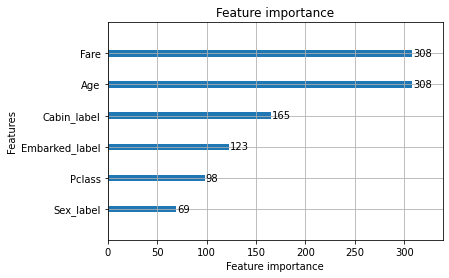

In [174]:
lgb.plot_importance(lgbm_model)

<Figure size 1440x1440 with 0 Axes>

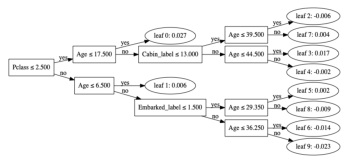

In [175]:
plt.figure(figsize=(20,20))
lgb.plot_tree(lgbm_model, tree_index=10)

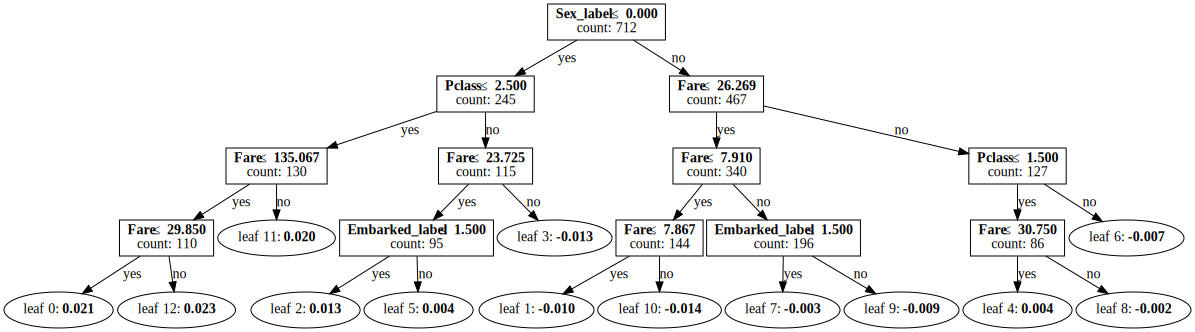

In [176]:
lgb.create_tree_digraph(lgbm_model, tree_index=1,  orientation = "vertical", show_info=['internal_count'])


## Model metadata interpretation

In [106]:
import json

In [154]:
tree_dump = lgbm_model.dump_model()["tree_info"][1]

In [155]:
def _get_nodes_info(node):
    tree_nodes = {}
    children_left = {}
    children_right = {}
    node_index = 0
    
    def _walk_tree(node, node_id):
        nonlocal node_index
        tree_nodes[node_id] = node
        if node.get("split_index") is None:
            children_left[node_id] = -1
            children_right[node_id] = -1
            return

        node_index += 1
        children_left[node_id] = node_index
        _walk_tree(node.get("left_child"), node_index)
        
        node_index += 1
        children_right[node_id] = node_index
        _walk_tree(node.get("right_child"), node_index)
        
    def _convert_dict_to_list(my_dict):
        my_list = [-1] * len(my_dict)
        for key, value in my_dict.items():
            my_list[key] = value
        return my_list
        
    _walk_tree(node, node_index)

    for node in tree_nodes.values():
        node.pop("left_child", None)
        node.pop("right_child", None)
        
    children_left_list = _convert_dict_to_list(children_left)
    children_right_list = _convert_dict_to_list(children_right)
    tree_node_list = _convert_dict_to_list(tree_nodes)
    
    return tree_node_list, children_left_list, children_right_list


In [156]:
tree_nodes, children_left, children_right = _get_nodes_info(tree_dump["tree_structure"])

In [157]:
print(children_left)
print(children_right)

[1, 2, 3, 4, -1, -1, -1, 8, 9, -1, -1, -1, 13, 14, 15, -1, -1, 18, -1, -1, 21, 22, -1, -1, -1]
[12, 7, 6, 5, -1, -1, -1, 11, 10, -1, -1, -1, 20, 17, 16, -1, -1, 19, -1, -1, 24, 23, -1, -1, -1]


In [153]:
tree_nodes[7]

{'split_index': 2,
 'split_feature': 2,
 'split_gain': 17.808000564575195,
 'threshold': 23.725000000000005,
 'decision_type': '<=',
 'default_left': True,
 'missing_type': 'None',
 'internal_value': 0.004239,
 'internal_weight': 27.1344,
 'internal_count': 115}

# dtreeviz

In [ ]:
ShadowLightGBMTree

In [184]:
light_dtree = ShadowLightGBMTree(lgbm_model, tree_index=1, x_data=X_train, y_data=y_train, feature_names=features, target_name=target, class_names=[0,1] )
